Removal efficiencies (per plant):
                       Plant  Primary  Secondary  Total
    Chengdu Cooperative WWTP    62.67      52.85   94.6
         Unity Township WWTP    62.71      39.39   91.0
Aviation Harbor Phase I WWTP    57.53      49.65   91.6
       Hedong WWTP, Jianyang    58.54      55.88   89.3

Friedman test (Primary, Secondary, Total):
  statistic = 8.0000, p = 0.018316

Pairwise Wilcoxon signed-rank tests (paired by plant):
  Primary vs Secondary: stat = 0.0000, p = 0.125000
  Primary vs Total: stat = 0.0000, p = 0.125000
  Secondary vs Total: stat = 0.0000, p = 0.125000


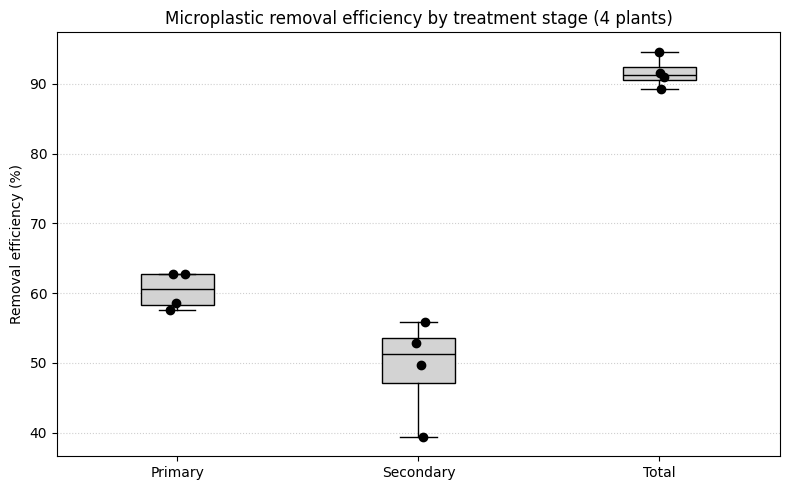

In [3]:
# Removal efficiency of the stages at removing microplastics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import re

FILE = "T3_removal_rates.csv"

def normalize_col(c):
    """Normalize column names for robust matching."""
    c = str(c).strip().lower()
    c = re.sub(r'[^a-z0-9]+', '_', c)
    return re.sub(r'_+', '_', c).strip('_')

try:
    p = Path(FILE)
    df_raw = pd.read_csv(p)
    
    # Normalize and detect columns
    norm_map = {c: normalize_col(c) for c in df_raw.columns}
    df = df_raw.rename(columns=norm_map)
    cols = df.columns.tolist()

    # Auto-detect necessary columns
    def find_col(keywords):
        for col in cols:
            if all(kw in col for kw in keywords):
                return col
        return None

    # Find proper names
    primary_col = find_col(['primary'])
    secondary_col = find_col(['secondary'])
    total_col = find_col(['total'])
    plant_col = find_col(['plant']) or find_col(['wwtp']) or find_col(['location'])
    
    if not all([plant_col, primary_col, secondary_col, total_col]):
        raise KeyError("Could not find all required columns (Plant, Primary, Secondary, Total).")

    # Build clean efficiency DataFrame
    df_eff = df[[plant_col, primary_col, secondary_col, total_col]].dropna(how="all").copy()
    df_eff = df_eff.rename(columns={
        plant_col: "Plant", primary_col: "Primary",
        secondary_col: "Secondary", total_col: "Total"
    })
    
    # Ensure numeric and handle percentage formatting (if values are small, assume fractions)
    for c in ["Primary", "Secondary", "Total"]:
        df_eff[c] = pd.to_numeric(df_eff[c].astype(str).str.replace('%', ''), errors='coerce')
        # If max value is <= 1, it's probably a fraction, so convert to percent
        if df_eff[c].max() <= 1.0 and df_eff[c].max() > 0.0:
            df_eff[c] = df_eff[c] * 100
    
    df_eff = df_eff.dropna(subset=["Primary", "Secondary", "Total"]).reset_index(drop=True)
    
except FileNotFoundError:
    print(f"ERROR: Input file '{INPUT_FILE}' not found. Please ensure it is in the same directory.")
    exit()
except KeyError as e:
    print(f"ERROR: Column detection failed: {e}. Check your CSV headers. Available columns: {cols}")
    exit()

# Treatment-stage removal efficiencies
print("Removal efficiencies (per plant):")
print(df_eff.to_string(index=False))

# Friedman test (paired nonparametric across 3 stages)
primary = df_eff["Primary"].values
secondary = df_eff["Secondary"].values
total = df_eff["Total"].values

friedman_stat, friedman_p = stats.friedmanchisquare(primary, secondary, total)
print("\nFriedman test (Primary, Secondary, Total):")
print(f"  statistic = {friedman_stat:.4f}, p = {friedman_p:.6f}")

# Pairwise Wilcoxon signed-rank tests (paired comparisons)
pairs = [("Primary", "Secondary"), ("Primary", "Total"), ("Secondary", "Total")]
print("\nPairwise Wilcoxon signed-rank tests (paired by plant):")
for a, b in pairs:
    stat, p = stats.wilcoxon(df_eff[a], df_eff[b], zero_method='wilcox', alternative='two-sided')
    print(f"  {a} vs {b}: stat = {stat:.4f}, p = {p:.6f}")

# Treatment-stage efficiencies (Boxplot)
plt.figure(figsize=(8,5))
stages = ["Primary", "Secondary", "Total"]
vals = [df_eff[s].values for s in stages]

plt.boxplot(vals, labels=stages, patch_artist=True,
            boxprops=dict(facecolor='lightgray'),
            medianprops=dict(color='black'))

for i, s in enumerate(stages):
    y = df_eff[s].values
    x = np.full(len(y), i + 1) + (np.random.rand(len(y)) - 0.5) * 0.08 
    plt.scatter(x, y, color='black', zorder=3)
    
plt.ylabel("Removal efficiency (%)")
plt.title(f"Microplastic removal efficiency by treatment stage ({len(df_eff)} plants)")
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()